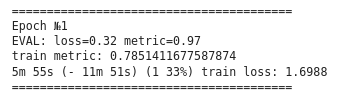

# Imports

In [1]:
#import keras
import os
import datasets
import numpy as np
import pandas as pd
import transformers
import sklearn.metrics
#import tensorflow as tf
import tqdm.notebook as tqdm
import sklearn.model_selection
import matplotlib.pyplot as plt

#pytorch

import torch
# from torcheval.metrics import MultilabelA
from torchmetrics.classification import Accuracy
#from torchsummary import summary
from torch import nn
from torch import optim
from torchinfo import summary
import torch.nn.functional as F

from sklearn.model_selection import train_test_split

/home/bob1ch/Рабочий стол/NN-NLP/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MODEL_PATH = 'models'
MAX_TOKENS = 32
MAX_LENGTH = 32

# Dataset

Get the dataset from [here](https://tatoeba.org/en/downloads). Preferably use russian to english translations.

Use a custom tokenizer that can add bos and eos tokens (pass `add_special_tokens=True` when calling the tokenizer to add them).

In [3]:
class Tokenizer(transformers.GPT2Tokenizer):

    def build_inputs_with_special_tokens(self, token_ids_0, token_ids_1=None):
        if token_ids_1 is None:
            return [self.bos_token_id, *token_ids_0, self.eos_token_id]

        return [self.bos_token_id, *token_ids_0, self.bos_token_id, *token_ids_1, self.eos_token_id]

In [4]:
tokenizer = Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token_id = tokenizer.eos_token_id

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'Tokenizer'.
/home/bob1ch/Рабочий стол/NN-NLP/venv/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [5]:
def to_tokenize(data):
    return tokenizer(data, max_length=MAX_TOKENS, truncation=True, padding=True)['input_ids']

In [6]:
data = pd.read_csv('seq2seq_dataset.tsv', 
            sep='\t', 
            on_bad_lines='skip',
            names=['id_1', 'rus', 'id_2', 'eng'])[['rus', 'eng']]

X, y = to_tokenize(data['rus'].to_list()), to_tokenize(data['eng'].to_list())
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.7, shuffle=True, random_state=27)

In [7]:
def pad_collate(batch):
    (inp, out_BOS, out_EOS, masking_PAD) = zip(*batch)
    inp = torch.nn.utils.rnn.pad_sequence(inp, batch_first=True, padding_value=tokenizer.eos_token_id)
    out_BOS = torch.nn.utils.rnn.pad_sequence(out_BOS, batch_first=True, padding_value=tokenizer.eos_token_id)
    out_EOS = torch.nn.utils.rnn.pad_sequence(out_EOS, batch_first=True, padding_value=tokenizer.eos_token_id)
    masking_PAD = torch.nn.utils.rnn.pad_sequence(masking_PAD, batch_first=True, padding_value=tokenizer.eos_token_id)

    return inp, out_BOS, out_EOS, masking_PAD

def get_dataloader(batch, X, y):
    X = np.array(X) #Торч поругался, что я не могу сделать отрицательный степ
    inp = torch.LongTensor(X.copy()).to('cuda') #а потом он ещё поругался, что в массиве у меня отрицательный страйд и попросил .copy()
    out_BOS = torch.LongTensor(y).to('cuda')[:, :-1]
    out_EOS = torch.LongTensor(y).to('cuda')[:, 1:]
    masking_PAD = (out_BOS != tokenizer.pad_token_id).to('cuda')
    masking_PAD[:, 0] = True # я получаю маску по BOS [50625, ..., 30, 50625] -> [False, ..., True, False] -> [True, ..., True, False]
    data = torch.utils.data.TensorDataset(inp,
                                          out_BOS,
                                          out_EOS,
                                          masking_PAD)
    return torch.utils.data.DataLoader(data, batch_size=batch, shuffle=True, collate_fn=pad_collate)

data = get_dataloader(256, X_train, y_train)
data_test = get_dataloader(256, X_test, y_test)

In [17]:
inp, out_BOS, out_EOS, masking_PAD = next(iter(data))
out_EOS, masking_PAD

(tensor([[   40,  1101,  1016,  ..., 50256, 50256, 50256],
         [ 2990,  1053,   587,  ..., 50256, 50256, 50256],
         [   40,  4601,   345,  ..., 50256, 50256, 50256],
         ...,
         [ 2437,  3105,   345,  ..., 50256, 50256, 50256],
         [   40,   423,   734,  ..., 50256, 50256, 50256],
         [   40,  6520,   284,  ..., 50256, 50256, 50256]], device='cuda:0'),
 tensor([[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]], device='cuda:0'))

In [18]:
out_EOS[0], masking_PAD[0]

(tensor([   40,  1101,  1016,   284,   466,   345,   257,  2661,    13, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256], device='cuda:0'),
 tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False], device='cuda:0'))

In [19]:
out_EOS[0][masking_PAD[0]], tokenizer.decode(out_EOS[0][masking_PAD[0]])

(tensor([   40,  1101,  1016,   284,   466,   345,   257,  2661,    13, 50256],
        device='cuda:0'),
 "I'm going to do you a favor.<|endoftext|>")

In [22]:
#pad_collate бесполезен, я его убрать забыл
#бесполезен по той причине, что у нас все последовательности уже одинаковой длины
#см. Функцию to_tokenize!!
def get_dataloader(batch, X, y):
    X = np.array(X) #Торч поругался, что я не могу сделать отрицательный степ
    inp = torch.LongTensor(X.copy()).to('cuda') #а потом он ещё поругался, что в массиве у меня отрицательный страйд и попросил .copy()
    out_BOS = torch.LongTensor(y).to('cuda')[:, :-1]
    out_EOS = torch.LongTensor(y).to('cuda')[:, 1:]
    masking_PAD = (out_BOS != tokenizer.pad_token_id).to('cuda')
    masking_PAD[:, 0] = True # я получаю маску по BOS [50625, ..., 30, 50625] -> [False, ..., True, False] -> [True, ..., True, False]
    data = torch.utils.data.TensorDataset(inp,
                                          out_BOS,
                                          out_EOS,
                                          masking_PAD)
    return torch.utils.data.DataLoader(data, batch_size=batch, shuffle=True)

data = get_dataloader(256, X_train, y_train)
data_test = get_dataloader(256, X_test, y_test)

In [23]:
inp, out_BOS, out_EOS, masking_PAD = next(iter(data))
out_EOS, masking_PAD

(tensor([[   40,  1422,   470,  ..., 50256, 50256, 50256],
         [24119,  1595,   470,  ..., 50256, 50256, 50256],
         [ 1532,   314,   836,  ..., 50256, 50256, 50256],
         ...,
         [13787,  2125,   470,  ..., 50256, 50256, 50256],
         [13787,   655, 12120,  ..., 50256, 50256, 50256],
         [13787,  1297,   502,  ..., 50256, 50256, 50256]], device='cuda:0'),
 tensor([[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]], device='cuda:0'))

In [24]:
out_EOS[0], masking_PAD[0]

(tensor([   40,  1422,   470,  1612,   826,   783,    13, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256], device='cuda:0'),
 tensor([ True,  True,  True,  True,  True,  True,  True,  True, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False, False,
         False], device='cuda:0'))

In [25]:
out_EOS[0][masking_PAD[0]], tokenizer.decode(out_EOS[0][masking_PAD[0]])

(tensor([   40,  1422,   470,  1612,   826,   783,    13, 50256],
        device='cuda:0'),
 "I didn't mean right now.<|endoftext|>")

Since the dataset is rather large, you can omit the validation dataset and just use a set of test sentences after the training.

Create a dataset that returns the following
* A pair of tensors `((None, L), (None, P))` -- input sequence of tokens and output sequence of tokens to be fed into decoder (this should start with the BOS token)
* A tensor `(None, P)` -- output sequence of tokens to be predicted (this should end with EOS token)
* A tensor `(None, P)` -- a masking tensor marking padded tokens with 0

# Model

Create a model for training. The model should have two inputs: input sequence `(None, L)` and output sequence`(None, P)`. The model output is a single tensor `(None, P)` logits (or probabilities) of the next token predicted for each input one.

In [8]:
# def get_model(
#     units: int,
#     n_tokens: int,
#     n_labels: int,
#     n_stacks: int = 1,
#     bidirectional: bool = False,
#     name: str | None = None,
#     cell_type: type[keras.layers.Layer] = keras.layers.LSTMCell
# ) -> keras.Model:
#     '''Creates a model with RNN architecture for sequence to sequence classification.

#     Arguments:
#         units: dimensionality of RNN cells
#         n_tokens: number of tokens in the tokenizer dictionary
#         n_labels: number of labels to be predicted
#         n_stacks: number of RNN cells in the stack (1 -- no stacking)
#         bidirectional: whether or not the model is bidirectional
#         name: the model name
#         cell_type: type of a cell to use, either keras.layers.LSTMCell or keras.layers.GRUCell

#     Returns:
#         The model'''
#     ...

Try to add attention to your model (for example [additive attention](https://keras.io/api/layers/attention_layers/additive_attention/)), does it perform better?

In [5]:
class EncoderRNN(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, bidirectional, num_layers):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.cell_type = cell_type

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = cell_type(hidden_size, hidden_size, batch_first=True, bidirectional=bidirectional, num_layers=num_layers)

    def forward(self, input):
        embedded = self.embedding(input)
        output, hidden = self.rnn(embedded)
        if self.cell_type == torch.nn.LSTM:
                h, c = hidden
                h = h.view(self.num_layers, 2, -1, self.hidden_size).sum(dim=1)
                c = c.view(self.num_layers, 2, -1, self.hidden_size).sum(dim=1)
                hidden = (h, c)
        else:
            hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size).sum(dim=1)
            
        return output, hidden

class DecoderRNN(nn.Module):
    def __init__(self, cell_type, hidden_size, output_size, num_layers):
        super(DecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.rnn = cell_type(hidden_size, hidden_size, batch_first=True, num_layers=num_layers)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor):
        decoder_input = target_tensor
        embedded = self.embedding(decoder_input)
        output, hidden = self.rnn(embedded, encoder_hidden)
        output = self.out(output)
        return output

class Seq2seq(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, device, bidirectional, num_layers):
        super(Seq2seq, self).__init__()
        self.encoder = EncoderRNN(cell_type, input_size, hidden_size, bidirectional, num_layers).to(device)
        self.decoder = DecoderRNN(cell_type, hidden_size, input_size, num_layers).to(device)

    def forward(self, inp, out_BOS):
        encoder_outputs, encoder_hidden = self.encoder(inp)
        decoder_outputs = self.decoder(encoder_outputs, encoder_hidden, out_BOS)

        return decoder_outputs

In [10]:
model_LSTM = Seq2seq(torch.nn.LSTM, tokenizer.vocab_size, 128, 'cuda', True, 2)

In [6]:
model_GRU = Seq2seq(torch.nn.GRU, tokenizer.vocab_size, 128, 'cuda', True, 2)

In [17]:
summary(model_GRU)

Layer (type:depth-idx)                   Param #
Seq2seq                                  --
├─EncoderRNN: 1-1                        --
│    └─Embedding: 2-1                    6,432,896
│    └─GRU: 2-2                          494,592
├─DecoderRNN: 1-2                        --
│    └─Embedding: 2-3                    6,432,896
│    └─GRU: 2-4                          198,144
│    └─Linear: 2-5                       6,483,153
Total params: 20,041,681
Trainable params: 20,041,681
Non-trainable params: 0

In [14]:
class AttnEncoderRNN(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, bidirectional, num_layers):
        super(AttnEncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.bidirectional = bidirectional
        self.num_layers = num_layers
        self.cell_type = cell_type

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.rnn = cell_type(hidden_size, hidden_size, batch_first=True, bidirectional=bidirectional, num_layers=num_layers)

    def forward(self, input):
        embedded = self.embedding(input)
        output, hidden = self.rnn(embedded)
        if self.bidirectional:
            output = output.view(input.shape[0], -1, 2, self.hidden_size) # B, L, D*H
            output = output.sum(dim=-2)
            
            if self.cell_type == torch.nn.LSTM:
                h, c = hidden
                h = h.view(self.num_layers, 2, -1, self.hidden_size).sum(dim=1)
                c = c.view(self.num_layers, 2, -1, self.hidden_size).sum(dim=1)
                hidden = (h, c)
            else:
                hidden = hidden.view(self.num_layers, 2, -1, self.hidden_size).sum(dim=1)
            
        return output, hidden

class AttnDecoderRNN(nn.Module):
    def __init__(self, cell_type, hidden_size, output_size, num_layers):
        super(AttnDecoderRNN, self).__init__()
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=1, batch_first=True)
        self.rnn = cell_type(hidden_size, hidden_size, batch_first=True, num_layers=num_layers)
        self.out = nn.Linear(2 * hidden_size, output_size)

    def forward(self, encoder_outputs, encoder_hidden, target_tensor):
        decoder_input = target_tensor
        embedded = self.embedding(decoder_input)
        
        output, hidden = self.rnn(embedded, encoder_hidden)

        out, _ = self.attention(output, encoder_outputs, encoder_outputs)
        
        output = torch.cat((output, out), dim=-1)
        
        output = self.out(output)
        return output

class AttnSeq2seq(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, device, bidirectional, num_layers):
        super(AttnSeq2seq, self).__init__()
        self.encoder = AttnEncoderRNN(cell_type, input_size, hidden_size, bidirectional, num_layers).to(device)
        self.decoder = AttnDecoderRNN(cell_type, hidden_size, input_size, num_layers).to(device)

    def forward(self, inp, out_BOS):
        encoder_outputs, encoder_hidden = self.encoder(inp)
        decoder_outputs = self.decoder(encoder_outputs, encoder_hidden, out_BOS)

        return decoder_outputs

In [15]:
model_attn_forwdir = AttnSeq2seq(torch.nn.GRU, tokenizer.vocab_size, 128, 'cuda', True, 2)
summary(model_attn_forwdir)

Layer (type:depth-idx)                                  Param #
AttnSeq2seq                                             --
├─AttnEncoderRNN: 1-1                                   --
│    └─Embedding: 2-1                                   6,432,896
│    └─GRU: 2-2                                         494,592
├─AttnDecoderRNN: 1-2                                   --
│    └─Embedding: 2-3                                   6,432,896
│    └─MultiheadAttention: 2-4                          49,536
│    │    └─NonDynamicallyQuantizableLinear: 3-1        16,512
│    └─GRU: 2-5                                         198,144
│    └─Linear: 2-6                                      12,916,049
Total params: 26,540,625
Trainable params: 26,540,625
Non-trainable params: 0

# Training

Train your model using teacher forcing. The idea is that the model predicts the next token that should follow, so one part of the model (called encoder) reads the text and output some state containing information about the text read. The other part of the model (called decoder) reads and already generated text (or in case of the teacher forcing the expected output) and predicts the next token for each one. 

In [16]:
import time
import math

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [17]:
def train_epoch(dataloader, model, optimizer, criterion, teacher_forcing):

    total_loss = 0
    total_metric = 0
    for data in dataloader:
        inp, out_BOS, out_EOS, masking_PAD = data

        optimizer.zero_grad()

        decoder_outputs = model(inp, out_BOS)
        
        loss = criterion(
            decoder_outputs[masking_PAD],
            out_EOS[masking_PAD]
        )
        loss.backward()

        optimizer.step()
        decoder_outputs = decoder_outputs.argmax(-1)
        total_metric += (decoder_outputs[masking_PAD].detach().cpu().numpy() == out_EOS[masking_PAD].detach().cpu().numpy()).mean()
        total_loss += loss.item()

    return total_loss / len(dataloader), total_metric / len(dataloader)

In [18]:
def train(train_dataloader, model, n_epochs, learning_rate=0.001, eval_every=1,
               print_every=100, plot_every=100, end_teacher_forcing=1):
    start = time.time()
    plot_losses = []
    print_loss_total = 0
    plot_loss_total = 0

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    teacher_forcing = True
    for epoch in range(1, n_epochs):
        if epoch == end_teacher_forcing:
            teacher_forcing = False
        print('='*40)
        print(f'Epoch №{epoch}')
        loss, metric = train_epoch(train_dataloader, model, optimizer, criterion, teacher_forcing)
        
        print_loss_total += loss
        plot_loss_total += loss

        if epoch % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print(f"train metric: {metric}")
            print('train loss: %.4f' % (print_loss_avg))
        
        if epoch % eval_every == 0:
            loss_test, metric_test = evaluate(data_test, model, criterion)
            print(f'EVAL: loss={loss_test:.2f} metric={metric_test:.2f}')

        print('%s (%d %d%%)' % (timeSince(start, epoch / n_epochs),
                                        epoch, epoch / n_epochs * 100))

        if epoch % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

In [19]:
def evaluate(dataloader, model, criterion):
    
    with torch.no_grad():
        total_metric = 0
        total_loss = 0
        for data in dataloader:
            inp, out_BOS, out_EOS, masking_PAD = data

            decoder_outputs = model(inp, out_BOS)
            
            loss = criterion(
                decoder_outputs[masking_PAD],
                out_EOS[masking_PAD]
            )
            total_loss += loss.item()
            decoder_outputs = decoder_outputs.argmax(-1)
            total_metric += (decoder_outputs[masking_PAD].detach().cpu().numpy() == out_EOS[masking_PAD].detach().cpu().numpy()).mean()
            
    return total_loss / len(dataloader), total_metric / len(dataloader)


In [15]:
train(data, model_LSTM, 15, eval_every=1, print_every=1, plot_every=1, end_teacher_forcing=40)
torch.save(model_LSTM.state_dict(), os.path.join(MODEL_PATH, 'seq2seq_lstm'+'.pth'))

Epoch №1
train metric: 0.31815553375239686
train loss: 4.6006
EVAL: loss=3.68 metric=0.42
4m 36s (- 64m 37s) (1 6%)
Epoch №2
train metric: 0.46105215737693456
train loss: 3.3287
EVAL: loss=3.11 metric=0.49
9m 15s (- 60m 12s) (2 13%)
Epoch №3
train metric: 0.5112873696577879
train loss: 2.8995
EVAL: loss=2.81 metric=0.53
13m 54s (- 55m 38s) (3 20%)
Epoch №4
train metric: 0.544405265169458
train loss: 2.6245
EVAL: loss=2.61 metric=0.55
18m 32s (- 51m 0s) (4 26%)
Epoch №5
train metric: 0.5687198533038775
train loss: 2.4230
EVAL: loss=2.47 metric=0.57
23m 10s (- 46m 21s) (5 33%)
Epoch №6
train metric: 0.5885566914214224
train loss: 2.2598
EVAL: loss=2.35 metric=0.59
27m 49s (- 41m 44s) (6 40%)
Epoch №7
train metric: 0.6062058442929023
train loss: 2.1222
EVAL: loss=2.26 metric=0.60
32m 29s (- 37m 7s) (7 46%)
Epoch №8
train metric: 0.6208819004841066
train loss: 2.0059
EVAL: loss=2.19 metric=0.61
37m 8s (- 32m 29s) (8 53%)
Epoch №9
train metric: 0.6337794455863776
train loss: 1.9060
EVAL: lo

NameError: name 'model' is not defined

In [16]:
torch.save(model_LSTM.state_dict(), os.path.join(MODEL_PATH, 'seq2seq_lstm'+'.pth'))

In [22]:
%%time
train(data, model_GRU, 15, eval_every=1, print_every=1, plot_every=1, end_teacher_forcing=40)
torch.save(model_GRU.state_dict(), os.path.join(MODEL_PATH, 'seq2seq_gru'+'.pth'))

Epoch №1
train metric: 0.34192803198240984
train loss: 4.3222
EVAL: loss=3.47 metric=0.44
4m 22s (- 61m 10s) (1 6%)
Epoch №2
train metric: 0.4783177171394871
train loss: 3.1296
EVAL: loss=2.94 metric=0.50
8m 44s (- 56m 52s) (2 13%)
Epoch №3
train metric: 0.5235030630867337
train loss: 2.7263
EVAL: loss=2.67 metric=0.54
13m 9s (- 52m 38s) (3 20%)
Epoch №4
train metric: 0.554183713794994
train loss: 2.4648
EVAL: loss=2.49 metric=0.56
17m 33s (- 48m 16s) (4 26%)
Epoch №5
train metric: 0.5783230354238562
train loss: 2.2647
EVAL: loss=2.36 metric=0.58
21m 58s (- 43m 57s) (5 33%)
Epoch №6
train metric: 0.5988351642808118
train loss: 2.1036
EVAL: loss=2.26 metric=0.59
26m 22s (- 39m 33s) (6 40%)
Epoch №7
train metric: 0.6154914026489132
train loss: 1.9718
EVAL: loss=2.18 metric=0.60
30m 46s (- 35m 9s) (7 46%)
Epoch №8
train metric: 0.6300569751764089
train loss: 1.8621
EVAL: loss=2.12 metric=0.62
35m 9s (- 30m 45s) (8 53%)
Epoch №9
train metric: 0.6426896637407329
train loss: 1.7682
EVAL: los

In [20]:
%%time
train(data, model_attn_forwdir, 15, eval_every=1, print_every=1, plot_every=1, end_teacher_forcing=40)

Epoch №1
train metric: 0.4344214179310611
train loss: 3.6097
EVAL: loss=2.53 metric=0.57
5m 22s (- 75m 12s) (1 6%)
Epoch №2
train metric: 0.6207565415272478
train loss: 2.1531
EVAL: loss=2.01 metric=0.64
10m 41s (- 69m 29s) (2 13%)
Epoch №3
train metric: 0.6679992613289815
train loss: 1.7594
EVAL: loss=1.82 metric=0.67
16m 11s (- 64m 45s) (3 20%)
Epoch №4
train metric: 0.6933632075197977
train loss: 1.5480
EVAL: loss=1.74 metric=0.68
21m 38s (- 59m 31s) (4 26%)
Epoch №5
train metric: 0.7125153313572637
train loss: 1.4023
EVAL: loss=1.68 metric=0.69
27m 5s (- 54m 10s) (5 33%)
Epoch №6
train metric: 0.7275605118902942
train loss: 1.2936
EVAL: loss=1.66 metric=0.70
32m 34s (- 48m 51s) (6 40%)
Epoch №7
train metric: 0.7398033625306856
train loss: 1.2079
EVAL: loss=1.64 metric=0.70
37m 59s (- 43m 24s) (7 46%)
Epoch №8
train metric: 0.7502867311865447
train loss: 1.1378
EVAL: loss=1.64 metric=0.71
43m 26s (- 38m 0s) (8 53%)
Epoch №9
train metric: 0.759308961532796
train loss: 1.0786
EVAL: lo

In [41]:
torch.save(model_attn_forwdir.state_dict(), os.path.join(MODEL_PATH, 'seq2seq_attn'+'.pth'))

# Testing

Make a function for text translation. Translate some text and evaluate model performance.

Take note that your model is set for training. During the inference process you will have to use parts of the model independently (including the RNN cells).

In [16]:
# def translate(
#     text: str,
#     tokenizer: Tokenizer,
#     model: keras.Model,
#     max_len: int = 20
# ) -> str:
#     '''Predicts `text`translation using the `model`.

#     Arguments:
#         text: text to be translated
#         tokenizer: tokenizer to use
#         model: model ot use
#         max_len: maximum length of the prediction (in tokens)

#     Returns:
#         tranlated text'''
#     ...

In [11]:
import torch

def translate(
    text: str,
    tokenizer,
    model: nn.Module,
    max_len: int = 20,
    attention: bool = False
) -> str:
    '''Predicts `text` translation using the `model`.

    Arguments:
        text: text to be translated
        tokenizer: tokenizer to use
        model: model to use
        max_len: maximum length of the prediction (in tokens)

    Returns:
        translated text'''

    input_ids = tokenizer(text, return_tensors="pt")['input_ids'].to('cuda')
    encoder_outputs, encoder_hidden = model.encoder(input_ids)

    decoder_input = torch.tensor([[tokenizer.bos_token_id]]).to('cuda')
    decoder_hidden = encoder_hidden
    generated_tokens = []

    for _ in range(max_len):
        embedded = model.decoder.embedding(decoder_input)
        decoder_output, decoder_hidden = model.decoder.rnn(embedded, decoder_hidden)
        if attention:
            out, _ = model.decoder.attention(decoder_output, encoder_outputs, encoder_outputs)
            output = torch.cat((decoder_output, out), dim=-1)
            output_token_logits = model.decoder.out(output[:, -1, :])
        else:
            output_token_logits = model.decoder.out(decoder_output[:, -1, :])
        output_token = torch.argmax(output_token_logits, dim=-1)
        generated_tokens.append(output_token.item())

        if output_token.item() == tokenizer.eos_token_id:
           break
        decoder_input = output_token.unsqueeze(0)
    translated_text = tokenizer.decode(generated_tokens, skip_special_tokens=True)
    return translated_text


In [18]:
#без атентиона
corpus = ['Доброе утро.',
          'Привет мир!', 
          'Какой чудесный день!',
          'Кот сидит на столе.',
          'Я люблю пиццу.', 
          'Принцесса была больна.',
          'ВЫфрои3424 ЫВФ Афыва']

for document in corpus:
    print(translate(document, tokenizer, model_LSTM, max_len=30))

Good morning.
I'm coming down!
What a lovely day, the one is on the floor.
The cat is sitting on the table.
I like pizza.
The princess was sick.
The village and the United States is called the capital of the capital of Japan.


In [12]:
#без атентиона
corpus = ['Доброе утро.',
          'Привет мир!', 
          'Какой чудесный день!',
          'Кот сидит на столе.',
          'Я люблю пиццу.', 
          'Принцесса была больна.',
          'ВЫфрои3424 ЫВФ Афыва']

for document in corpus:
    print(translate(document, tokenizer, model_GRU, max_len=30))

Good morning.
The peace is a good idea.
What a day!
The cat is sitting on the table.
I like pizza.
The princess was ill.
The war is located in the United States.


In [39]:
#атентиона
corpus = ['Доброе утро.',
          'Привет мир!', 
          'Какой чудесный день!',
          'Кот сидит на столе.',
          'Я люблю пиццу.', 
          'Принцесса была больна.',
          'ВЫфрои3424 ЫВФ Афыва']

for document in corpus:
    print(translate(document, tokenizer, model_attn_forwdir, max_len=30, attention=True))

Good morning.
Break the world!
What a wonderful day!
The cat is sitting on the table.
I like pizza.
The princess was sick.
The United Nations of the United States is written by the United States.
